# Введение в искусственные нейронные сети
# Урок 4. Сверточные нейронные сети

## Практическое задание
Вариант 1. (простой)

* обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
* оценить рост точности при увеличении ширины сети (больше ядер)
* оценить рост точности при увеличении глубины сети (больше слоев)
* сравнить с точностью полносвязной сети для этой выборки


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, losses, datasets

from tensorflow.keras.losses import categorical_crossentropy

###AlexNet

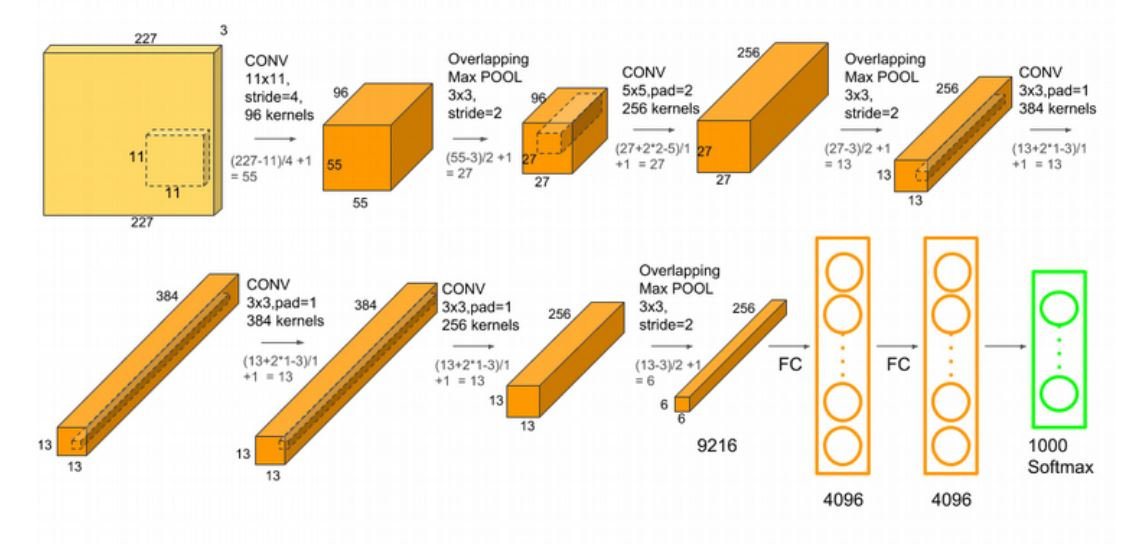

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)

x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# создание модели по схеме AlexNet c учетом будущих эксперименов
def CreateAlexNetLayersList(width=1, depth=1):
    
    layers_list = None
    layers_list = [layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]),

        layers.Conv2D(96*width, 11, strides=4, padding='same'),
        layers.Lambda(tf.nn.local_response_normalization),
        layers.Activation('relu'),
        layers.MaxPooling2D(3, strides=2),

        layers.Conv2D(256*width, 5, strides=4, padding='same'),
        layers.Lambda(tf.nn.local_response_normalization),
        layers.Activation('relu'),
        layers.MaxPooling2D(3, strides=2),

        layers.Conv2D(384*width, 3, strides=4, padding='same'),
        layers.Activation('relu'),

        layers.Conv2D(384*width, 3, strides=4, padding='same'),
        layers.Activation('relu')]
    
    for i in range(depth):
        layers_list += [layers.Conv2D(256*width, 3, strides=4, padding='same'),
                       layers.Activation('relu')]

    layers_list += [layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')]

    return layers_list

In [4]:
# инициализация пустой модели
model = Sequential(CreateAlexNetLayersList())

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 56, 56, 96)        0         
                                                                 
 activation (Activation)     (None, 56, 56, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         614656    
                                                        

In [5]:
# компиляция модели
model.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy, 
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train, 
                    batch_size=64, 
                    epochs=20, 
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
907/907 [==============================] - 118s 121ms/step - loss: 0.6580 - accuracy: 0.7371 - val_loss: 0.3633 - val_accuracy: 0.8700
Epoch 2/20
907/907 [==============================] - 108s 119ms/step - loss: 0.3391 - accuracy: 0.8786 - val_loss: 0.3084 - val_accuracy: 0.8870
Epoch 3/20
907/907 [==============================] - 108s 119ms/step - loss: 0.2957 - accuracy: 0.8937 - val_loss: 0.2786 - val_accuracy: 0.8930
Epoch 4/20
907/907 [==============================] - 108s 119ms/step - loss: 0.2714 - accuracy: 0.9020 - val_loss: 0.2631 - val_accuracy: 0.9030
Epoch 5/20
907/907 [==============================] - 108s 119ms/step - loss: 0.2459 - accuracy: 0.9122 - val_loss: 0.2877 - val_accuracy: 0.8980
Epoch 6/20
907/907 [==============================] - 108s 119ms/step - loss: 0.2265 - accuracy: 0.9180 - val_loss: 0.2423 - val_accuracy: 0.9110
Epoch 7/20
907/907 [==============================] - 108s 119ms/step - loss: 0.2088 - accuracy: 0.9246 - val_loss: 0.2439 -

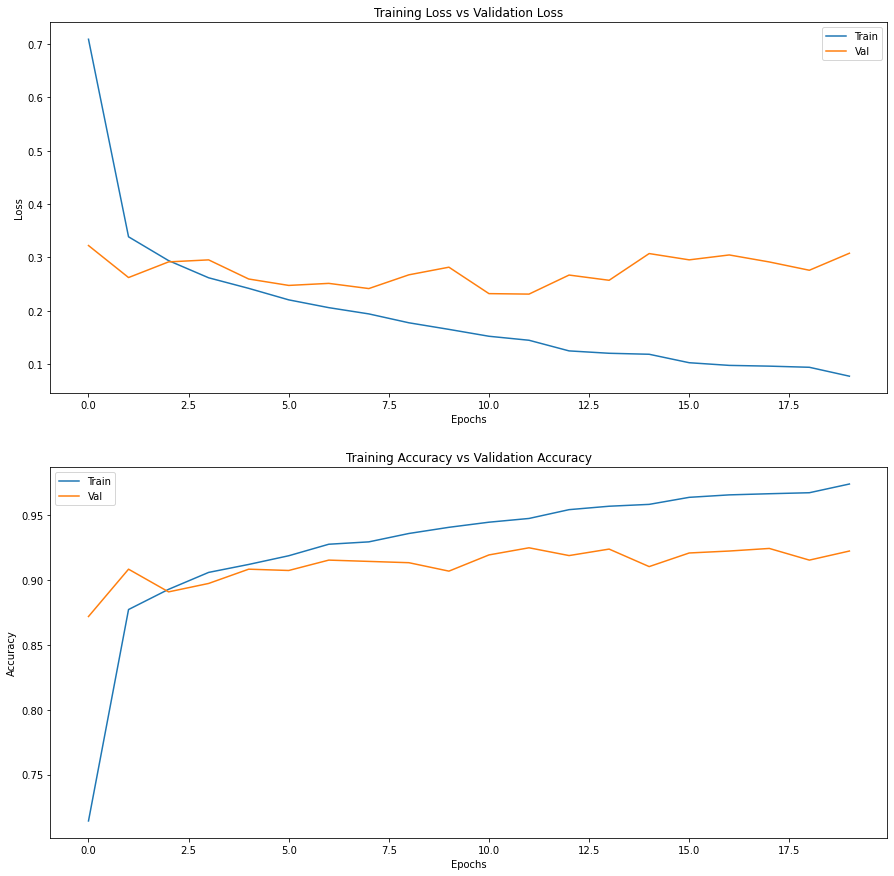

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [9]:
test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))


313/313 [==============================] - 7s 23ms/step - loss: 0.3825 - accuracy: 0.9145
Test loss 0.3825, accuracy 91.45%


### Оценка влияния увеличения ширины и глубины сети

In [6]:
result_metrics = None
result_metrics = []

In [7]:
def test_model(width=1, depth=1, epochs=10, batch_size=64):

    model = Sequential(CreateAlexNetLayersList(width=width, depth=depth))
  
    # компиляция модели
    model.compile(optimizer='adam',
                  loss=losses.sparse_categorical_crossentropy, 
                  metrics=['accuracy'])

    model.fit(x=x_train, y=y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_val, y_val),
                    verbose=0)
    
    [loss, accuracy] = model.evaluate(x_test, y_test)
    
    return loss, accuracy

In [8]:
epochs = 10
batch_size = 64

for w in [1, 2, 3]:
    for d in [1, 5, 10]:

        experiment_name = f'width: {w}, depth: {d}'
        print(experiment_name)

        loss, accuracy = test_model(width=w, depth=d, epochs=10, batch_size=64)
        print("Test loss {:.4f}, accuracy {:.2f}%".format(loss, accuracy * 100))       
        result_metrics.append([experiment_name, loss, accuracy])


width: 1, depth: 1
313/313 [==============================] - 7s 22ms/step - loss: 0.3283 - accuracy: 0.9080
Test loss 0.3283, accuracy 90.80%
width: 1, depth: 5
313/313 [==============================] - 7s 24ms/step - loss: 2.3026 - accuracy: 0.1000
Test loss 2.3026, accuracy 10.00%
width: 1, depth: 10
313/313 [==============================] - 8s 24ms/step - loss: 2.3026 - accuracy: 0.1000
Test loss 2.3026, accuracy 10.00%
width: 2, depth: 1
313/313 [==============================] - 15s 47ms/step - loss: 0.3042 - accuracy: 0.9107
Test loss 0.3042, accuracy 91.07%
width: 2, depth: 5
313/313 [==============================] - 16s 52ms/step - loss: 0.3131 - accuracy: 0.8974
Test loss 0.3131, accuracy 89.74%
width: 2, depth: 10
313/313 [==============================] - 18s 56ms/step - loss: 2.3026 - accuracy: 0.1000
Test loss 2.3026, accuracy 10.00%
width: 3, depth: 1
313/313 [==============================] - 25s 78ms/step - loss: 0.2606 - accuracy: 0.9109
Test loss 0.2606, accuracy 

In [9]:
import pandas as pd

# Оценка влияния увеличения ширины сети на тестовой выборке
pd.DataFrame(result_metrics, columns=['experiment',
                              'loss', 'accuracy'
                              ]).\
                              sort_values('accuracy',ascending=False)

,experiment,loss,accuracy
6,"width: 3, depth: 1",0.260649,0.9109
3,"width: 2, depth: 1",0.304172,0.9107
0,"width: 1, depth: 1",0.328301,0.9080
4,"width: 2, depth: 5",0.313132,0.8974
1,"width: 1, depth: 5",2.302614,0.1000
2,"width: 1, depth: 10",2.302615,0.1000
5,"width: 2, depth: 10",2.302601,0.1000
7,"width: 3, depth: 5",2.302617,0.1000
8,"width: 3, depth: 10",2.302626,0.1000


Из полученной таблицы видно, что увеличение ширины, в общем, положительно сказывается на точности. А вот увеличение глубины не дает однозначного улучшения качества. Иногда получаются очень странные результаты.

Точность полносвязной сети (из практического задания урока 2):

In [12]:
result_dense = []
result_dense.append(['2-слойная сеть',  0.940521, 0.891000, 0.8817])
result_dense.append(['3-слойная сеть',  0.948021, 0.883500, 0.8776])
result_dense.append(['5-слойная сеть',  0.937563, 0.877333, 0.8684])
result_dense.append(['10-слойная сеть', 0.352604, 0.389583, 0.3822])
# Оценка accuracy
pd.DataFrame(result_dense, columns=['mod_name','mod_accuracy','mod_val_accuracy', 'test_accuracy']).sort_values('mod_val_accuracy',ascending=False)

,mod_name,mod_accuracy,mod_val_accuracy,test_accuracy
0,2-слойная сеть,0.940521,0.891000,0.8817
1,3-слойная сеть,0.948021,0.883500,0.8776
2,5-слойная сеть,0.937563,0.877333,0.8684
3,10-слойная сеть,0.352604,0.389583,0.3822


**Вывод**

* Увеличение ширины (количества ядер) может приводить к росту точности. 
* Увеличение глубины (количества слоев) требует дальнейшего изучения. 
* Лучшая точность полносвязной сети для тестовой выборки в исследуемом наборе данных составляет 0.8817, что меньше (даже самого плохого вразумительного результата 0.8974) полученной точности сверточной нейронной сети AlexNet.